<h1 style="text-align: center; font-size: 50px;">Multimodal RAG Chatbot with Langchain and ML Flow Evaluation</h1>

Retrieval-Augmented Generation (RAG) is an architectural approach that can enhance the effectiveness of large language model (LLM) applications using customized data. In this example, we use LangChain, an orchestrator for language pipelines, to build an assistant capable of loading information from a web page and use it for answering user questions. We'll also use the DeepEval platform to evaluate, observe and protect the LLM responses.

# Notebook Overview
- Imports
- Configurations
- Verify Assets
- Data Loading
- Creation of Chunks
- Retrieval
- Model Setup
- Chain Creation
- Model Service 

# Imports

By using our Local GenAI workspace image, many of the necessary libraries to work with RAG already come pre-installed - in our case, we just need to add the connector to work with PDF documents

In [1]:
%pip install -r ../requirements.txt --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
# # === Standard Library Imports ===
import base64
import json
import logging
import mimetypes
import os
import sys
import time
import warnings
from collections import defaultdict
from copy import deepcopy
from datetime import datetime
from pathlib import Path
from typing import Any, Dict, List, Optional, TypedDict
from IPython.display import Image, display
from statistics import mean
from PIL import Image as PILImage
import io

# === Third-Party Library Imports ===
import mlflow
import pandas as pd
import torch
from chromadb.config import Settings
from langchain.chains import ConversationalRetrievalChain
from langchain.document_loaders import JSONLoader, WebBaseLoader
from langchain.memory import ConversationBufferMemory
from langchain.schema import StrOutputParser
from langchain.schema.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter, MarkdownHeaderTextSplitter
from langchain.vectorstores import Chroma
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_community.vectorstores.utils import filter_complex_metadata
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.documents import Document as CoreDocument
from langchain_core.embeddings import Embeddings
from langchain_core.output_parsers import StrOutputParser as CoreStrOutputParser
from langchain_core.runnables import Runnable, RunnableLambda, RunnablePassthrough
from tqdm import tqdm
from transformers import SiglipModel, SiglipProcessor
from langchain.chains.question_answering import load_qa_chain
from sentence_transformers import CrossEncoder
from langchain.llms import LlamaCpp

# === ML Inference Backends ===
from llama_cpp import Llama

# Define the relative path to the 'core' directory (one level up from current working directory)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# === Project-Specific Imports ===
from src.local_genai_judge import LocalGenAIJudge
from src.utils import (
    configure_hf_cache,
    load_config,
    mlflow_evaluate_setup,
)

USER_AGENT environment variable not set, consider setting it to identify your requests.
2025-07-18 06:44:09.915119: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-18 06:44:09.972947: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752821050.002323    6903 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752821050.011476    6903 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752821050.054241    6903 computation_place

# Configurations

In [3]:
warnings.filterwarnings("ignore")

In [4]:
# Create logger
logger = logging.getLogger("multimodal_rag_logger")
logger.setLevel(logging.INFO)

formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s", datefmt="%Y-%m-%d %H:%M:%S") 
stream_handler = logging.StreamHandler()
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)
logger.propagate = False

In [5]:
CONFIG_PATH = "../configs/config.yaml"

CONTEXT_DIR: Path = Path("../data/context")             
CHROMA_DIR: Path = Path("../data/chroma_store")     
MEMORY_PATH: Path = Path("../data/memory/memory.json")
MANIFEST_PATH: Path = CHROMA_DIR / "manifest.json"

IMAGE_DIR = CONTEXT_DIR / "images"
WIKI_METADATA_DIR = CONTEXT_DIR / "wiki_flat_structure.json"

MLFLOW_EXPERIMENT_NAME = "AIStudio-Multimodal-Chatbot-Experiment"
MLFLOW_RUN_NAME = "AIStudio-Multimodal-Chatbot-Run"
MLFLOW_MODEL_NAME = "AIStudio-Multimodal-Model"

LOCAL_MODEL_PATH = "/home/jovyan/datafabric/llama3.1-8b-instruct/Meta-Llama-3.1-8B-Instruct-Q8_0.gguf"
INTERNVL_MODEL_PATH = "/home/jovyan/datafabric/InternVL3-8B-Instruct-Q8_0-1/InternVL3-8B-Instruct-Q8_0.gguf"
MM_PROJ_PATH = "/home/jovyan/datafabric/mmproj-InternVL3-8B-Instruct-Q8_0-1/mmproj-InternVL3-8B-Instruct-Q8_0.gguf"

DEMO_FOLDER = "../demo"
MLFLOW_MODEL_NAME = "AIStudio-Multimodal-Chatbot-Model"

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [7]:
start_time = time.time()  

logger.info('Notebook execution started.')

2025-07-18 06:44:13 - INFO - Notebook execution started.



# Verify Assets

In [8]:
# If folders do not exist, create them automatically
for _dir in (CHROMA_DIR, MEMORY_PATH.parent):
    _dir.mkdir(parents=True, exist_ok=True)

if not MEMORY_PATH.exists():
    MEMORY_PATH.write_text("{}", encoding="utf‑8")

In [9]:
def log_asset_status(asset_path: str, asset_name: str, success_message: str, failure_message: str) -> None:
    """
    Logs the status of a given asset based on its existence.

    Parameters:
        asset_path (str): File or directory path to check.
        asset_name (str): Name of the asset for logging context.
        success_message (str): Message to log if asset exists.
        failure_message (str): Message to log if asset does not exist.
    """
    if Path(asset_path).exists():
        logger.info(f"{asset_name} is properly configured. {success_message}")
    else:
        logger.info(f"{asset_name} is not properly configured. {failure_message}")

log_asset_status(
    asset_path=CONFIG_PATH,
    asset_name="Config",
    success_message="",
    failure_message="Please check if the configs.yaml was propely connfigured in your project on AI Studio."
)

log_asset_status(
    asset_path=INTERNVL_MODEL_PATH,
    asset_name="Local InternVL-8B model",
    success_message="",
    failure_message="Please create and download the required assets in your project on AI Studio if you want to use local model.")

log_asset_status(
    asset_path=MM_PROJ_PATH,
    asset_name="Vision projector (.gguf)",
    success_message="",
    failure_message="Download mmproj-InternVL3-8B-Instruct-Q8_0.gguf")

log_asset_status(
    asset_path=WIKI_METADATA_DIR,
    asset_name="wiki_flat_structure.json",
    success_message="",
    failure_message="Place JSON Wiki Pages in data/")

log_asset_status(
    asset_path=CONTEXT_DIR,
    asset_name="CONTEXT",
    success_message="",
    failure_message="Please check if CONTEXT path was downloaded correctly in your project on AI Studio."
)

log_asset_status(
    asset_path=CHROMA_DIR,
    asset_name="CHROMA",
    success_message="",
    failure_message="Please check if CHROMA path was downloaded correctly in your project on AI Studio."
)

log_asset_status(
    asset_path=MEMORY_PATH,
    asset_name="MEMORY",
    success_message="",
    failure_message="Please check if the MEMORY path was propely connfigured in your project on AI Studio."
)


log_asset_status(
    asset_path=MANIFEST_PATH,
    asset_name="MANIFEST",
    success_message="",
    failure_message="Please check if the MANIFEST path was propely connfigured in your project on AI Studio."
)

2025-07-18 06:44:13 - INFO - Config is properly configured. 
2025-07-18 06:44:13 - INFO - Local InternVL-8B model is properly configured. 
2025-07-18 06:44:13 - INFO - Vision projector (.gguf) is properly configured. 
2025-07-18 06:44:13 - INFO - wiki_flat_structure.json is properly configured. 
2025-07-18 06:44:13 - INFO - CONTEXT is properly configured. 
2025-07-18 06:44:13 - INFO - CHROMA is properly configured. 
2025-07-18 06:44:13 - INFO - MEMORY is properly configured. 
2025-07-18 06:44:13 - INFO - MANIFEST is properly configured. 


# Memory Store

In [10]:
class SimpleKVMemory:
    """Very small persistent key‑value store (JSON on disk)."""
    def __init__(self, file_path: Path) -> None:
        self.file_path = file_path
        self._store    = self._load()

    # Public ------------
    def get(self, key: str) -> Optional[str]:
        return self._store.get(key)

    def set(self, key: str, value: str) -> None:
        self._store[key] = value
        self._dump()

    # Private -----------
    def _load(self) -> Dict[str, str]:
        if self.file_path.exists():
            try:
                with self.file_path.open("r", encoding="utf‑8") as f:
                    return json.load(f)
            except Exception as exc:
                logger.warning("Memory load failed (%s). Starting fresh.", exc)
        return {}

    def _dump(self) -> None:
        self.file_path.parent.mkdir(parents=True, exist_ok=True)
        with self.file_path.open("w", encoding="utf‑8") as f:
            json.dump(self._store, f, ensure_ascii=False, indent=2)

memory = SimpleKVMemory(MEMORY_PATH)


In [11]:
class RAGState(TypedDict, total=False):
    topic            : str
    query            : str
    answer           : Optional[str]
    retrieved_docs   : List[Document]
    images           : List[str]
    from_memory      : Optional[bool]
    messages         : List[Dict[str, Any]]   # full chat‑history if you need it

## Configuration of HuggingFace caches

In the next cell, we configure HuggingFace cache, so that all the models downloaded from them are persisted locally, even after the workspace is closed. This is a future desired feature for AI Studio and the GenAI addon.

In [12]:
# Configure HuggingFace cache
configure_hf_cache()

In [13]:
# Initialize HuggingFace Embeddings
embeddings = HuggingFaceEmbeddings(
    model_name="intfloat/e5-large-v2",
    cache_folder="/tmp/hf_cache"
)

## Configuration and Secrets Loading

In this section, we load configuration parameters and API keys from separate YAML files. This separation helps maintain security by keeping sensitive information (API keys) separate from configuration settings.

- **config.yaml**: Contains non-sensitive configuration parameters like model sources and URLs
- **secrets.yaml**: Contains sensitive API keys for services like Galileo and HuggingFace

In [14]:
config = load_config(CONFIG_PATH)

# Data Loading & Cleaning

We load wiki-pages from `wiki_flat_structure.json`, but:
* remove any image name that  
  – is empty / `None`  
  – contains invalid characters (e.g. the `==image_0==` placeholders)  
  – has an extension not in {png, jpg, jpeg, webp, gif}  
  – points to a file that does **not** exist in `data/images/`
* log every discarded image so we can fix the parser later.

In [15]:
VALID_EXTS = {".png", ".jpg", ".jpeg", ".webp", ".gif"}

WIKI_METADATA_DIR   = Path(WIKI_METADATA_DIR)
IMAGE_DIR = Path(IMAGE_DIR)

def load_mm_docs_clean(json_path: Path, img_dir: Path) -> List[Document]:
    """
    Load wiki Markdown + image references from *json_path*.
    • Filters out images with bad extensions or missing files.
    • Logs the first 20 broken refs.
    • Returns a list[Document] where metadata = {source, images}
    """
    bad_imgs, docs = [], []

    rows = json.loads(json_path.read_text("utf-8"))
    for row in rows:
        images_ok = []
        for name in row.get("images", []):
            if not name:                                     # empty / placeholder
                bad_imgs.append((row["path"], name, "empty"))
                continue
            ext = Path(name).suffix.lower()
            if ext not in VALID_EXTS:                       # unsupported ext
                bad_imgs.append((row["path"], name, f"ext {ext}"))
                continue
            img_path = img_dir / name
            if not img_path.is_file():                      # missing on disk
                bad_imgs.append((row["path"], name, "missing file"))
                continue
            images_ok.append(name)

        docs.append(
            Document(
                page_content=row["content"],
                metadata={"source": row["path"], "images": images_ok},
            )
        )

    # ---- summary logging ----------------------------------------------------
    if bad_imgs:
        logger.warning("⚠️ %d broken image refs filtered out", len(bad_imgs))
        for src, name, reason in bad_imgs[:20]:
            logger.debug("  » %s → %s (%s)", src, name or "<EMPTY>", reason)
    else:
        logger.info("✅ no invalid image refs found")

    return docs

mm_raw_docs = load_mm_docs_clean(WIKI_METADATA_DIR, Path(IMAGE_DIR))
def log_stage(name: str, docs: List[Document]):
    logger.info(f"{name}: {len(docs)} docs, avg_tokens={sum(len(d.page_content) for d in docs)/len(docs):.0f}")
log_stage("Docs loaded", mm_raw_docs)

2025-07-18 06:44:19 - WARNING - ⚠️ 94 broken image refs filtered out
2025-07-18 06:44:19 - INFO - Docs loaded: 558 docs, avg_tokens=3082


# Creation of Chunks
Here, we split the loaded documents into chunks, so we have smaller and more specific texts to add to our vector database.

In [16]:
def chunk_documents(
    docs,
    chunk_size: int = 1200,
    overlap: int = 200,
) -> list[Document]:
    """
    1) Split each wiki page on Markdown headers (#, ## …) to keep logical
       sections together.
    2) Recursively break long sections to <= `chunk_size` chars with `overlap`.
    3) Prefix every chunk with its page‑title and store the title in metadata.
    """
    header_splitter = MarkdownHeaderTextSplitter(
        headers_to_split_on=[("#", "title"), ("##", "section")]
    )
    recursive_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=overlap,
    )

    all_chunks: list[Document] = []
    for doc in docs:
        page_title = Path(doc.metadata["source"]).stem.replace("-", " ")

        # 1️⃣ section‑level split (returns list[Document])
        section_docs = header_splitter.split_text(doc.page_content)

        for section in section_docs:
            # 2️⃣ size‑based split inside each section
            tiny_texts = recursive_splitter.split_text(section.page_content)

            for idx, tiny in enumerate(tiny_texts):
                all_chunks.append(
                    Document(
                        page_content=f"{page_title}\n\n{tiny.strip()}",
                        metadata={
                            "title": page_title,
                            "source": doc.metadata["source"],
                            "section_header": section.metadata.get("header", ""),
                            "chunk_id": idx,
                        },
                    )
                )
    if all_chunks:
        avg_len = int(mean(len(c.page_content) for c in all_chunks))
        logger.info(
            "Chunking complete: %d docs → %d chunks (avg %d chars)",
            len(docs),
            len(all_chunks),
            avg_len,
        )
    else:
        logger.warning("Chunking produced zero chunks for %d docs", len(docs))

    return all_chunks

splits = chunk_documents(mm_raw_docs)

2025-07-18 06:44:19 - INFO - Chunking complete: 558 docs → 2574 chunks (avg 713 chars)


# Setup Embeddings & Vector Store
Here we setup Siglip for Image embeddings, and also store our cleaned text chunks embeddings into Chroma.

In [17]:
# ---------------------------------------------------------------------------
#  Helper: walk all docs once and gather *unique* image vectors + metadata
# ---------------------------------------------------------------------------
def _collect_image_vectors():
    """
    Scans every wiki page for image references and returns three parallel lists:
        img_paths : list[str]   → full file‑system paths (for SigLIP)
        img_ids   : list[str]   → unique key per (page, image) pair
        img_meta  : list[dict]  → {"source": wiki_page, "image": file_name}
    Runs in < 1 s even for thousands of docs.
    """
    img_paths, img_ids, img_meta = [], [], []
    seen = set()

    for doc in mm_raw_docs:                         # raw wiki pages
        src = doc.metadata["source"]
        for name in doc.metadata.get("images", []): # list[str]
            img_id = f"{src}::{name}"
            if img_id in seen:
                continue                            # de‑dupe
            seen.add(img_id)

            img_paths.append(str(IMAGE_DIR / name))
            img_ids.append(img_id)
            img_meta.append({"source": src, "image": name})

    return img_paths, img_ids, img_meta


In [18]:
# --- Image‑embedding helper  (place this once, ABOVE the vector‑store code) --
class SiglipEmbeddings(Embeddings):
    def __init__(self,
                 model_id: str = "google/siglip2-base-patch16-224",
                 device: str | None = None):
        from transformers import SiglipModel, SiglipProcessor
        import torch, PIL.Image as PILImage
        self.device    = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.model     = SiglipModel.from_pretrained(model_id).to(self.device)
        self.processor = SiglipProcessor.from_pretrained(model_id)
        self.torch     = torch
        self.PILImage  = PILImage

    # ---- private helpers ---------------------------------------------------
    def _embed_text(self, txts):
        inp = self.processor(text=txts, return_tensors="pt",
                             padding=True, truncation=True).to(self.device)
        with self.torch.no_grad():
            return self.model.get_text_features(**inp).cpu().numpy()

    def _embed_imgs(self, paths):
        imgs = [self.PILImage.open(p).convert("RGB") for p in paths]
        inp  = self.processor(images=imgs, return_tensors="pt").to(self.device)
        with self.torch.no_grad():
            return self.model.get_image_features(**inp).cpu().numpy()

    # ---- LangChain API -----------------------------------------------------
    def embed_documents(self, docs):          # list[str]  (image paths)
        return self._embed_imgs(docs).tolist()

    def embed_query(self, txt):               # single str  (textual query)
        return self._embed_text([txt])[0].tolist()

siglip_embeddings = SiglipEmbeddings()


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [19]:
# ── 1) TEXT store ────────────────────────────────────────────────────────────
def _current_manifest() -> List[str]:
    """Returns an ordered list of every Markdown/JSON context file we index."""
    return sorted(str(p.resolve()) for p in CONTEXT_DIR.rglob("*.json"))

def _needs_rebuild() -> bool:
    if not CHROMA_DIR.exists() or not MANIFEST_PATH.exists():
        return True
    try:
        old = json.loads(MANIFEST_PATH.read_text())
    except Exception:
        return True
    return old != _current_manifest()

def _save_manifest(manifest: List[str]) -> None:
    CHROMA_DIR.mkdir(parents=True, exist_ok=True)
    MANIFEST_PATH.write_text(json.dumps(manifest, indent=2))

def _build_text_db() -> Chroma:
    collection = "mm_text"
    if _needs_rebuild():
        logger.info("Re‑indexing text context → %s …", CHROMA_DIR)
        chroma = Chroma.from_documents(
            documents        = splits,            # you already created these
            embedding        = embeddings,
            collection_name  = collection,
            persist_directory= str(CHROMA_DIR),
        )
        _save_manifest(_current_manifest())
        return chroma
    logger.info("Loading existing Chroma index from %s", CHROMA_DIR)
    return Chroma(
        collection_name   = collection,
        persist_directory = str(CHROMA_DIR),
        embedding_function= embeddings,
    )

text_db = _build_text_db()

# ── 2) IMAGE store ───────────────────────────────────────────────────────────
image_db = Chroma(
    collection_name    = "mm_image",
    persist_directory  = str(CHROMA_DIR),   # SAME dir as text db
    embedding_function = siglip_embeddings, # <-- class you kept
)

# Populate vectors *only* if this looks empty -------------------------------
if not image_db._collection.count():
    img_paths, img_ids, img_meta = _collect_image_vectors()
    image_db.add_texts(texts=img_paths, metadatas=img_meta, ids=img_ids)
    image_db.persist()
    logger.info("Indexed %d unique images.", len(img_paths))
else:
    logger.info("Loaded existing image index (%d vectors).",
                image_db._collection.count())



2025-07-18 06:44:25 - INFO - Loading existing Chroma index from ../data/chroma_store
2025-07-18 06:44:25 - INFO - Loaded existing image index (738 vectors).


# Retrieval

We transform the texts and images into embeddings and store them in a vector database. This allows us to perform similarity search, and proper retrieval of documents

In [20]:

_cross_encoder = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")


def retrieve_mm(
    query: str,
    k_txt: int = 8,
    k_img: int = 8,
    fetch_k: int = 20,
    hybrid_weights: Dict[str, float] = {"init": 0.6, "rerank": 0.4},
    boost_slug: float = 0.1,
) -> Dict[str, Any]:
    """
    1) Coarse recall: top `fetch_k` docs + init_scores
    2) Cross‑encoder rerank: rerank_scores
    3) Build hybrid_score = w1*init + w2*rerank + optional slug boost
    4) Sort by hybrid_score, then pick top‑k_txt **without repeating sources**
    5) Image retrieval with $in filter
    """
    # 1) Coarse recall
    docs_and_init = text_db.similarity_search_with_score(query, k=fetch_k)
    docs, init_scores = zip(*docs_and_init)

    # 2) Rerank
    pairs = [(query, d.page_content) for d in docs]
    rerank_scores = _cross_encoder.predict(pairs)

    # 3) Compute hybrid scores (+ slug boost)
    slug = query.lower().replace(" ", "-")
    hybrid_scores = []
    for d, init, rerank in zip(docs, init_scores, rerank_scores):
        score = hybrid_weights["init"] * init + hybrid_weights["rerank"] * rerank
        if slug in d.metadata.get("source", "").lower():
            score += boost_slug
        hybrid_scores.append(score)

    # 4) Deduplicate & select top‑k_txt
    scored_docs = list(zip(docs, hybrid_scores))
    scored_docs.sort(key=lambda x: x[1], reverse=True)

    top_docs_and_scores = scored_docs[:k_txt]

    if not top_docs_and_scores:
        return {"docs": [], "images": [], "scores": []}
    selected_docs, final_scores = zip(*top_docs_and_scores)

    # 5) Image retrieval
    sources = [d.metadata["source"] for d in selected_docs]
    q_emb = siglip_embeddings.embed_query(query)
    img_hits = image_db.similarity_search_by_vector(
        q_emb,
        k=k_img * 2,
        filter={"source": {"$in": sources}},
    )
    images = [img.page_content for img in img_hits[:k_img]]

    return {
        "docs": list(selected_docs),
        "images": images,
        "scores": list(final_scores),
    }

# Model Setup

In this notebook, we provide three different options for loading the model:
 * **local**: by loading the internvl3-8b-instruct-Q8_0 model from the asset downloaded on the project
 * **hugging-face-local** by downloading a DeepSeek model from Hugging Face and running locally
 * **hugging-face-cloud** by accessing the Mistral model through Hugging Face cloud API (requires HuggingFace API key saved on secrets.yaml)

This choice can be set in the config.yaml file. The model deployed on the bottom cells of this notebook will load the choice from the config file.

In [21]:

# llm_mm = LlamaCpp(
#     model_path=INTERNVL_MODEL_PATH,
#     n_gpu_layers=-1,
#     n_ctx=32768,
#     n_batch=256,
#     f16_kv=True,
#     verbose=False,
#     # pass any extra args down into llama-cpp-python
#     model_kwargs={"mmproj_path": MM_PROJ_PATH},
# )

# Chain Creation
In this part, we define a pipeline that receives a question and context, formats the context documents, and uses the Qwen chat model to answer the question based on the provided context. The output is then formatted as a string for easy reading.

In [22]:
# --------  MODEL + QA PIPELINE  --------
from PIL import Image as PILImage
import torch, gc, time, logging
from typing import Dict, Any, List
import numpy as np
import torch
from transformers import AutoModel, AutoTokenizer, BitsAndBytesConfig, AutoImageProcessor # <-- ADD THIS
import gc, time
from collections import defaultdict
from langchain.docstore.document import Document

logger = logging.getLogger(__name__)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

SYSTEM_PROMPT = """
You are **AI Studio DevOps Assistant**. Everything you know for this turn is inside
the <context> block. Follow *all* rules below:
1. **Answer comprehensively from the context.**
   - Provide detailed, thorough responses using all relevant information
   - If the answer is missing, write: "I don't know based on the provided context."
   - Never invent facts or rely on outside knowledge.
2. **Be detailed and structured.**
   - For procedures, provide complete numbered steps with explanations
   - Include the source from the context at the end of your answer in brackets and back ticks e.g. [``].
   - Quote file paths / commands in back-ticks
   - Include relevant examples and details from the context
3. **Use all available information.**
   - Draw from multiple documents when relevant
   - Synthesize information to provide complete answers
   - Explain what's in the images provided
"""

class InternVLMM:
    """
    Minimal, self-contained multimodal QA wrapper around InternVL3-8B-Instruct.
    Retrieval remains external (retrieve_mm). This class:
      • loads / resets the model
      • builds the prompt (<context>…)
      • optionally attaches the top retrieved image
      • returns the model’s answer
    """
    MODEL_NAME = "OpenGVLab/InternVL3-8B-Instruct"

    def __init__(self):
        self.model = None
        self.tok   = None
        self.image_processor = None
        self._load()

    # ---------- public API ----------
    def generate(self, query: str, **retrieval_kwargs) -> Dict[str, Any]: # <-- Update return type hint
        """
        Run retrieval, prompt assembly, and model generation.
        Returns a dictionary with the text reply and a list of used image paths.
        """
        if self.model is None or self.tok is None:
            return {"reply": "Error: model not initialised.", "used_images": []}
    
        # 1) retrieve docs & images
        hits = retrieve_mm(query, **retrieval_kwargs)
        docs: List[Any]   = hits["docs"]
        images: List[str] = hits["images"] # This is the list of paths you want to return
    
        if not docs and not images:
            return {"reply": "I don't know based on the provided context.", "used_images": []}
    
        # ... (The middle of the function remains the same) ...
        context = "\n\n".join(
            f"### Source: {d.metadata.get('source','unknown')}\n{d.page_content}"
            for d in docs
        )
        prompt = (
            f"{SYSTEM_PROMPT}\n\n<context>\n{context}\n</context>\n\nUser query:\n{query}"
        )
        if images:
            prompt += f"\n\n[{len(images)} image(s) are provided for analysis]"
    
        # 4) generate
        try:
            self._clear_cuda()
            pixel_values = self._process_images(images) if images else None
            reply = self.model.chat(
                self.tok,
                pixel_values,
                prompt,
                generation_config=dict(
                    max_new_tokens=8916,
                    pad_token_id=self.tok.pad_token_id,
                    eos_token_id=self.tok.eos_token_id,
                ),
            )
            self._clear_cuda()
            
            # Return a dictionary instead of just the text string ## MODIFIED ##
            return {"reply": reply, "used_images": images}

        except RuntimeError as e:
            msg = str(e).lower()
            if "cuda" in msg or "out of memory" in msg:
                logger.warning("CUDA error – resetting model: %s", e)
                self._reset()
                error_reply = "I ran into a GPU memory error – please try again."
            else:
                logger.error("Runtime error: %s", e)
                error_reply = f"Error: {e}"
            return {"reply": error_reply, "used_images": images}
    # ---------- internal helpers ----------
    def _load(self):
        """Load tokenizer, image_processor, & model. Handles 8-bit quant on GPUs, fp32 on CPU.""" # <-- (Updated docstring)
        logger.info("Loading %s ...", self.MODEL_NAME)
        gc.collect()
        self._clear_cuda()

        self.tok = AutoTokenizer.from_pretrained(
            self.MODEL_NAME, trust_remote_code=True
        )
        if self.tok.pad_token is None:
            self.tok.pad_token = self.tok.eos_token

        # ADD THIS BLOCK to load the image processor
        self.image_processor = AutoImageProcessor.from_pretrained(
            self.MODEL_NAME, trust_remote_code=True
        )

        q_cfg = (
            BitsAndBytesConfig(load_in_8bit=True, llm_int8_threshold=6.0)
            if DEVICE == "cuda"
            else None
        )

        self.model = AutoModel.from_pretrained(
            self.MODEL_NAME,
            quantization_config=q_cfg,
            torch_dtype=(torch.bfloat16 if DEVICE == "cuda" else torch.float32),
            low_cpu_mem_usage=True,
            trust_remote_code=True,
            device_map="auto" if DEVICE == "cuda" else None,
        ).eval()
        logger.info("Model loaded on %s.", DEVICE)

    def _reset(self):
        """Free everything and reload (called after persistent CUDA errors)."""
        logger.warning("Resetting InternVL model …")
        del self.model, self.tok, self.image_processor # <-- ADD self.image_processor
        self.model = self.tok = self.image_processor = None # <-- ADD self.image_processor
        gc.collect()
        self._clear_cuda()
        time.sleep(1)
        self._load()

    def _process_images(self, image_paths: List[str]):
        """
        Convert a list of image filepaths to a single batched tensor.
        """
        if not image_paths:
            return None
        try:
            # Open all images from their file paths
            pil_images = [PILImage.open(p).convert("RGB") for p in image_paths]
            
            # The processor naturally handles a list of PIL images
            processed_data = self.image_processor(images=pil_images, return_tensors="pt")
            pixel_values = processed_data['pixel_values']

            # Match model device/dtype
            target_dtype = next(self.model.parameters()).dtype if self.model else torch.float32
            pixel_values = pixel_values.to(device=DEVICE, dtype=target_dtype)
            
            return pixel_values
            
        except Exception as e:
            logger.error("Image processing failed for one or more images: %s", e)
            return None

    @staticmethod
    def _clear_cuda():
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.synchronize()

mm = InternVLMM()

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


FlashAttention2 is not installed.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [23]:
import matplotlib.pyplot as plt
from PIL import Image as PILImage
import math
from typing import List

def display_images(image_paths: List[str], max_cols: int = 4):
    """
    Opens and displays a list of images from their file paths in a grid.

    Args:
        image_paths: A list of file paths to the images.
        max_cols: The maximum number of columns in the display grid.
    """
    if not image_paths:
        print("▶ No images to display.")
        return

    print(f"🖼️ Displaying {len(image_paths)} image(s):")
    
    # --- Calculate grid size ---
    num_images = len(image_paths)
    cols = min(num_images, max_cols)
    rows = math.ceil(num_images / cols)

    # --- Create figure and axes ---
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    
    # Flatten the axes array for easy iteration, and handle the case of a single image
    if num_images == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    # --- Loop through images and display them ---
    for i, path in enumerate(image_paths):
        ax = axes[i]
        try:
            # Open the image file
            img = PILImage.open(path)
            
            # Display the image on the appropriate subplot
            ax.imshow(img)
            ax.set_title(path.split('/')[-1], fontsize=8) # Use filename as title
            
        except FileNotFoundError:
            ax.text(0.5, 0.5, 'Image not found', ha='center', va='center', fontsize=9)
        except Exception as e:
            ax.text(0.5, 0.5, 'Error loading image', ha='center', va='center', fontsize=9)
            print(f"  - Error loading image '{path}': {e}")
        
        ax.axis('off') # Hide the x/y axis for a cleaner look

    # --- Hide any unused subplots ---
    for j in range(num_images, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


--- MODEL RESPONSE ---
To run blueprints locally, follow these the steps outlined in the provided context:

1. **Clone the Repository:**
   - Clone the `phoenix/phoenix-app-backend` repository first. This is the repository that contains the necessary files and configurations for running the blueprints locally.

2. **AWS Login:**
   - Ensure you are logged in with the correct AWS credentials. This is necessary to avoid access denied errors. You can use the AWS CLI or configure your environment variables to include your AWS credentials.

33 **Disable Migration and AWS Key Manager:**
   - In the `app\cloud\main.go` file, disable the migration process. This step is crucial to prevent any migration-related issues during local execution.
   - In the `business\sys\container\container.go` file, disable the AWS Key Manager. This step is necessary to avoid issues related to AWS Key Management during local execution.

4 **Create a Local `.env` File:**
   - Create a local `.env` file under the `ph

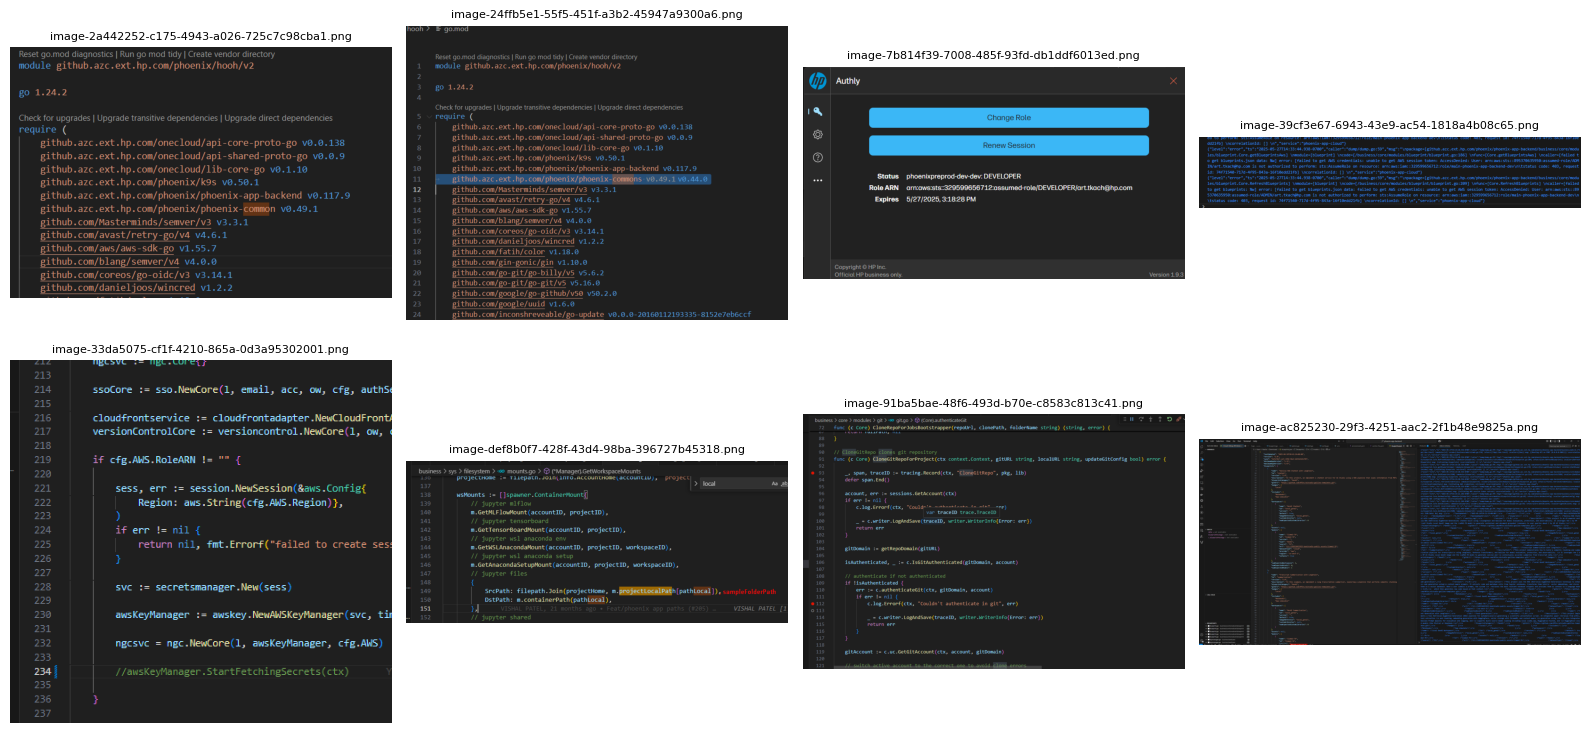

In [24]:

question = "How do i run blueprints locally?"

results = mm.generate(question)

# 4. Print the text response
print("--- MODEL RESPONSE ---")
print(results["reply"])
print("----------------------\n")

# 5. Display the images that the model used as context
display_images(results["used_images"])
# override retrieval knobs if needed
# print(mm.answer(question, k_txt=4, fetch_k=30))

In [ ]:
question2 = "What are some feature flags that i can enable in AIStudio?"
print(mm.generate(question2))          # defaults: k_txt=2, k_img=8, fetch_k=20 ...


In [ ]:
question3 = "How do i manually clean my environment without hooh?"
print(mm.generate(question3))          # defaults: k_txt=2, k_img=8, fetch_k=20 ...


In [ ]:
question4 = "How do I test a config after i sign it?"
print(mm.generate(question4))          # defaults: k_txt=2, k_img=8, fetch_k=20 ...


Built with ❤️ using Z by HP AI Studio.